## Using a Gaussian Mixture Clustering Algorithm to Inspect z = 6-8 Galaxies from JWST CEERS

In [25]:
# removing warnings
import warnings
warnings.filterwarnings('ignore')

import time
import numpy as np
import pandas as pd
import glob
import cv2  # .pngs into np array

%matplotlib inline
from cycler import cycler
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.lines import Line2D                          # custom legend
from PIL import Image                                        # making image scatter plot
from IPython.display import display                          # ''
from matplotlib.offsetbox import OffsetImage, AnnotationBbox # ''
from matplotlib.cbook import get_sample_data                 # ''
from astropy.table import QTable, Table, Column

from sklearn.manifold import TSNE
from sklearn import manifold, datasets
from sklearn.mixture import GaussianMixture

# LaTeX parameters for plotting
plt.rcParams['text.usetex']= True
plt.rcParams['mathtext.fontset']= 'custom'
plt.rcParams['mathtext.default']= 'rm'
plt.rcParams['axes.formatter.use_mathtext']=False

### Gathering image data and .xlsx file of labels
* **Note: list of IDs from filenames is not in the same order as list of IDs from .xlsx**
* **decided to keep all corresponding lists in the same order as files**

In [26]:
directory = 'multi_filter_pngs'
filenames = glob.glob(f'{directory}/*_crop.png')
image_data = [cv2.imread(i) for i in filenames]

# flattening images for t-SNE readability
flattenend_images = np.array([i.flatten() for i in image_data])
X = flattenend_images

In [27]:
# function for counting instances of something
def instances(column,target):
    inst = 0
    for i in column:
        if i == target:
            inst += 1
    return inst

In [28]:
# ---SAVING IDs---
IDs = []

# for multi-filter images
for i in filenames:
    index1 = (i.index('z')) + 3
    if i[index1] == '_':        # if file is z > 9
        index1 += 1
    i = i[index1:]              # getting rid of directory string & z number
    index2 = (i.index('F')) - 1
    ID = i[:index2]
    IDs.append(ID)
    
# ---SAVING LABELS & REASONS---
# excel file with IDs + labels + reasons for all 1816 sources
xlsx_df = pd.read_excel('Inspections\z = 6-8 Inspection Labels.xlsx')

labels = []
reasons = []

# loop through excel file and collect in the order of IDs list
for i in IDs:
    xlsx_row = list(xlsx_df['Source_ID']).index(int(i))
    labels.append(xlsx_df['Reliable_Source'][xlsx_row])
    reasons.append(xlsx_df['Reason'][xlsx_row])

# ---COUNTING INSTANCES---
total_spurious = instances(labels,0)
total_diff_spikes = instances(reasons,'diffraction spike')
total_close = instances(reasons,'close to another source')
total_edge_data = instances(reasons,'edge data')

print('out of '+str(len(IDs)) + ' sources, ' + str(total_spurious)+' spurious sources (' + str(round((total_spurious / (len(IDs)))*100)) + '%)\n')
print('diffraction spikes:        ',total_diff_spikes)
print('edge of data:              ',total_edge_data)
print('close to a bright source:  ',total_close)

out of 1816 sources, 57 spurious sources (3%)

diffraction spikes:         29
edge of data:               7
close to a bright source:   22


### t-SNE dimensionality reduction of photometric images

In [29]:
tsne = TSNE(n_components=2,verbose=1,random_state=12,
            perplexity=50,n_iter=1500,metric='euclidean')

print('...begin TSNE fit_transform...\n')
time_start = time.time()
X_tsne = tsne.fit_transform(X)
print('\nTime elapsed: {} seconds'.format(round((time.time() - time_start),2)))

...begin TSNE fit_transform...

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1816 samples in 1.357s...
[t-SNE] Computed neighbors for 1816 samples in 49.783s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1816
[t-SNE] Computed conditional probabilities for sample 1816 / 1816
[t-SNE] Mean sigma: 3778.147871
[t-SNE] KL divergence after 250 iterations with early exaggeration: 105.652924
[t-SNE] KL divergence after 1500 iterations: 2.110651

Time elapsed: 69.58 seconds


### Creating DataFrame

In [30]:
T = Table()
T['source_id'] = IDs
T['label'] = labels
T['reason'] = reasons
T['tsne_X'] = X_tsne[:,0]
T['tsne_y'] = X_tsne[:,1]

df = pd.DataFrame(np.array(T))
print(df[0:5])

  source_id  label reason    tsne_X    tsne_y
0     72897      1    nan  6.293349  1.973220
1     92777      1    nan  7.798584 -1.195176
2    100029      1    nan  0.447179 -0.819537
3    100052      1    nan  4.731133 -2.926434
4    100207      1    nan  5.644475 -4.897815


### t-SNE plot highlighting spurious sources

Text(0.5, 1.0, 't-SNE output')

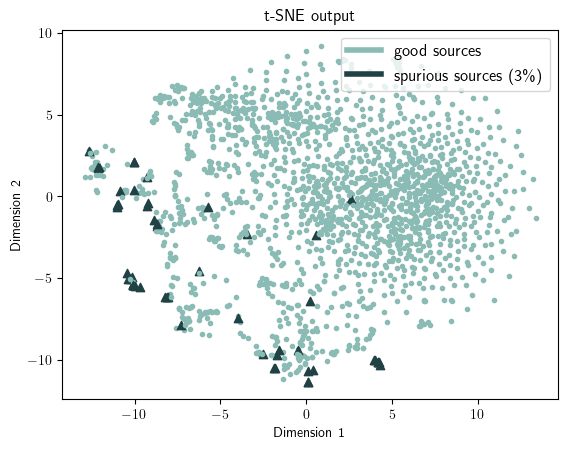

In [31]:
for i in range(len(T['source_id'])):
    if labels[i] == 0:
        plt.scatter(df['tsne_X'][i],df['tsne_y'][i],color='#214245',marker='^')
    else:
        plt.scatter(df['tsne_X'][i],df['tsne_y'][i],color='#8BBBB5',marker='.')

custom_lines = [Line2D([0], [0], color='#8BBBB5', lw=4),
                Line2D([0], [0], color='#214245', lw=4)]
plt.legend(custom_lines, ['good sources', 'spurious sources (3\%)'],fontsize='large',loc='upper right')        
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE output')

### t-SNE Interactive plot

In [32]:
scat = px.scatter(df,x='tsne_X', y='tsne_y', hover_name=df['source_id'], hover_data=['label'])
fig = go.FigureWidget(scat)
fig

FigureWidget({
    'data': [{'customdata': array([[1],
                                   [1],
               …

### t-SNE plot of images

In [33]:
def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
    if axis is None:
        axis = plt.gca()
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
        image = Image.open(image_path)
        image.thumbnail((250, 100), Image.Resampling.LANCZOS) #"resampling" term just increases resolution of image
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()

def show_tsne(x, y, selected_filenames):
    fig, axis = plt.subplots()
    fig.set_size_inches(17, 8, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=0.3, axis=axis)

<Figure size 640x480 with 0 Axes>

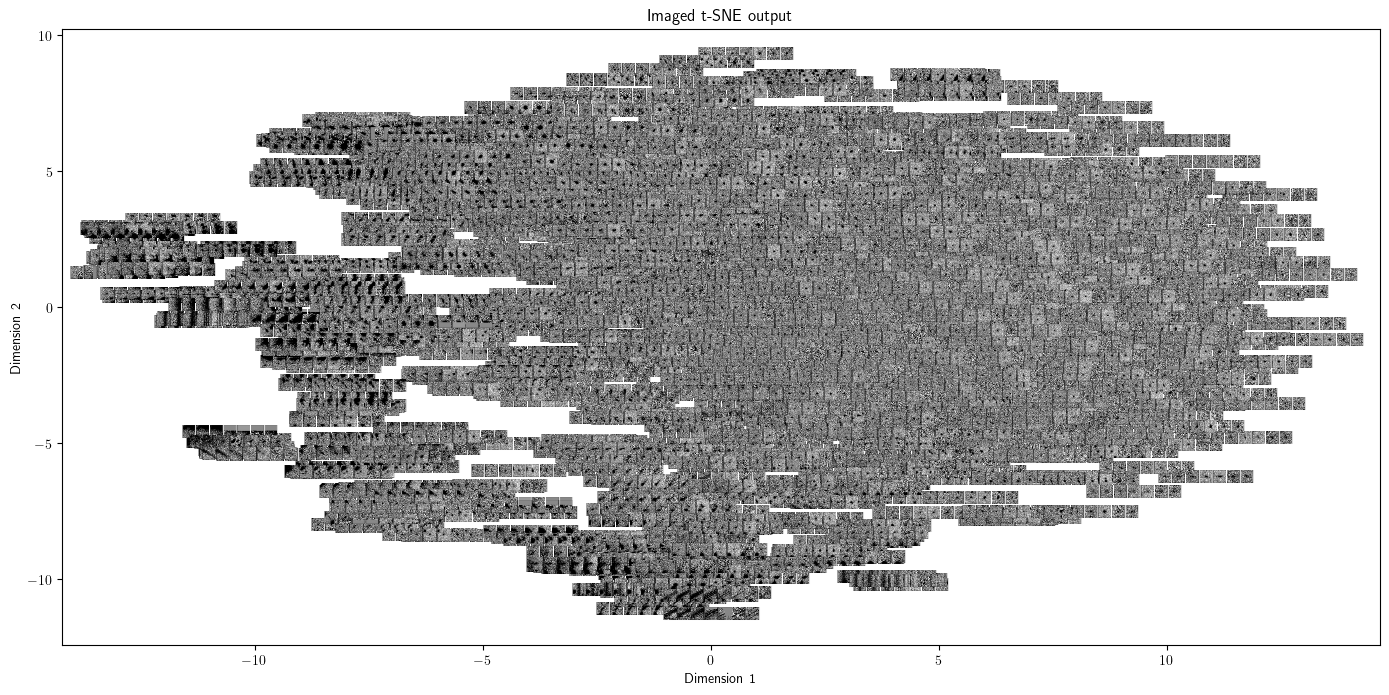

In [34]:
plt.gray()
show_tsne(df['tsne_X'],df['tsne_y'],filenames)
plt.title('Imaged t-SNE output')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

### Gaussian Mixture Clustering Algorithm

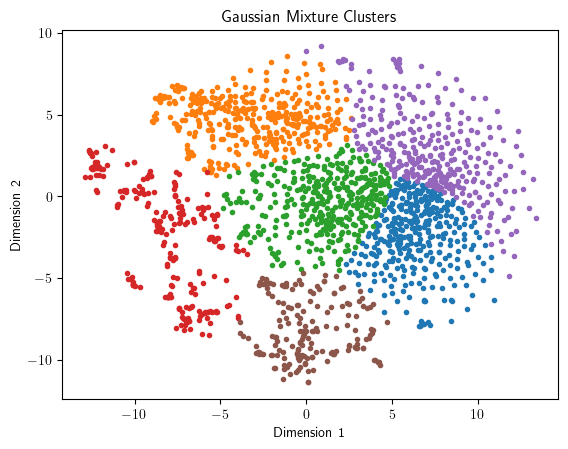

In [60]:
cluster_list = []

def plot_clusters(N): 
    model = GaussianMixture(n_components=N,random_state=12)
    model.fit(X_tsne)
    preds = model.predict(X_tsne)
    clusters = np.unique(preds)
    plt.title('Gaussian Mixture Clusters')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    
    for i in range(N):
        # indexes of sources for current cluster
        row = np.where(preds == clusters[i])
        l = 'cluster ' + str(i+1)
        # append sources for current cluster
        cluster_list.append(row)
        plt.scatter(X_tsne[row,0],X_tsne[row,1],label=l,marker='.')

# adjust function parameters if needed
plot_clusters(6)

### Inspecting proposed spurious region

In [61]:
# function that inspects each cluster
def inspect(cluster_list):
    
    # initialize stats 
    total_good = 0
    total_spurious = 0
    total_sources = 0
    cluster_num = 0        # keep track of current cluster
    spurious_clusters = [] # list of significantly spurious clusters
    
    # looping through each cluster
    for cluster in cluster_list:
        labels = [df['label'][i] for i in cluster[0]]
        reasons = [df['reason'][i] for i in cluster[0]]
        g = instances(labels,1)
        b = instances(labels,0)
        percent_spurious = round(((b/(g+b))*100))
        
        # if this cluster is significantly spurious, add to region
        if percent_spurious >= 5:
            spurious_clusters.append(cluster_num)
            total_sources += len(cluster[0])
            total_good += g
            total_spurious += b
        cluster_num += 1
    
    # return stats of region that fit our spurious criteria
    return spurious_clusters,total_sources,total_good,total_spurious

In [62]:
spurious_clusters,total_sources,total_good,total_spurious = inspect(cluster_list)

print(len(spurious_clusters),'spurious clusters found with current criteria ... combined stats of region:\n')
print(total_sources, 'total sources')
print(total_good, 'good')
print(total_spurious, ' spurious (out of 57 known)')

2 spurious clusters found with current criteria ... combined stats of region:

412 total sources
358 good
54  spurious (out of 57 known)


### Plotting spurious region

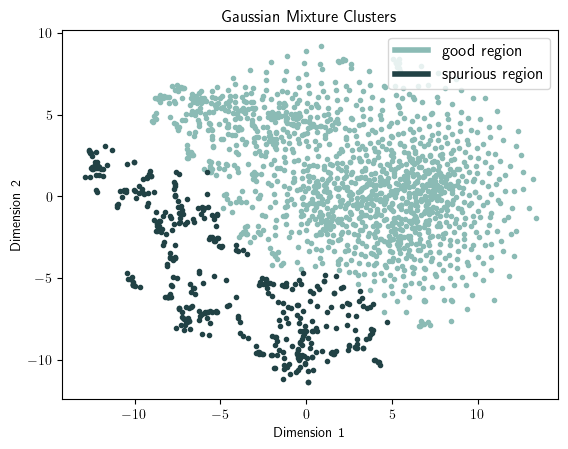

In [66]:
def plot_regions(N): 
    model = GaussianMixture(n_components=N,random_state=12)
    model.fit(X_tsne)
    preds = model.predict(X_tsne)
    clusters = np.unique(preds)
    plt.title('Gaussian Mixture Clusters')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    
    for i in range(N):
        # indexes of sources for current cluster
        row = np.where(preds == clusters[i])
        l = 'cluster ' + str(i+1)
        if i in spurious_clusters:
            plt.scatter(X_tsne[row,0],X_tsne[row,1],label=l,color='#214245',marker='.')
        else:
            plt.scatter(X_tsne[row,0],X_tsne[row,1],label=l,color='#8BBBB5',marker='.')     

custom_lines = [Line2D([0], [0], color='#8BBBB5', lw=4),
                Line2D([0], [0], color='#214245', lw=4)]
plt.legend(custom_lines, ['good region', 'spurious region'],fontsize='large',loc='upper right')

# adjust function parameters if needed
plot_regions(6)

### Displaying all spurious sources (57)
* **single-filter images: 51 X 51 pixels**
* **multi-filter images: 170 X 950 pixels**

ID: 11197
reason: edge data


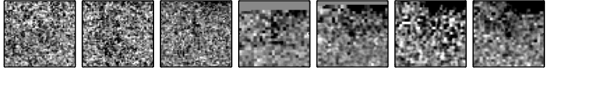

ID: 17129
reason: close to another source


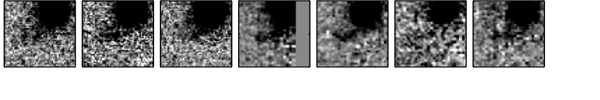

ID: 20953
reason: close to another source


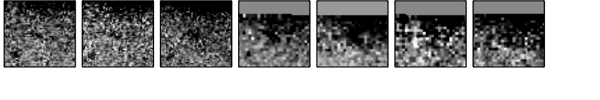

ID: 22295
reason: close to another source


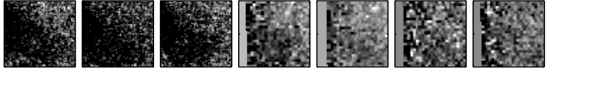

ID: 28774
reason: close to another source


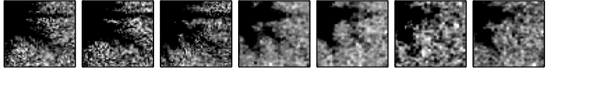

ID: 36643
reason: diffraction spike


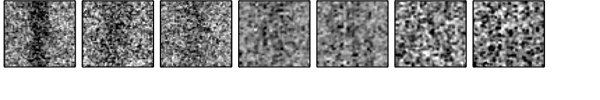

ID: 38680
reason: close to another source


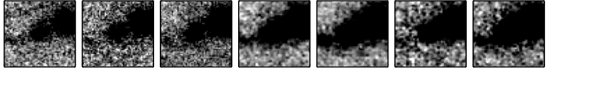

ID: 52667
reason: close to another source


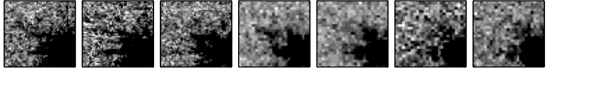

ID: 536
reason: diffraction spike


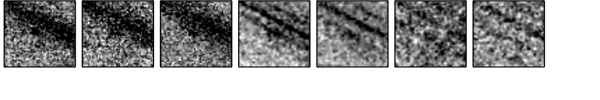

ID: 61019
reason: close to another source


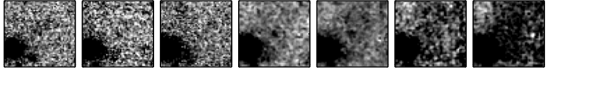

ID: 61539
reason: close to another source


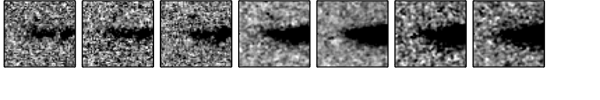

ID: 65467
reason: close to another source


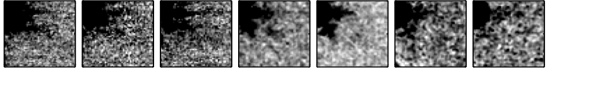

ID: 72648
reason: edge data


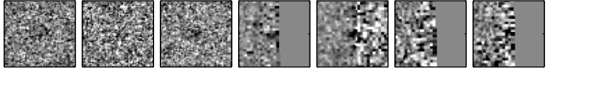

ID: 73800
reason: edge data


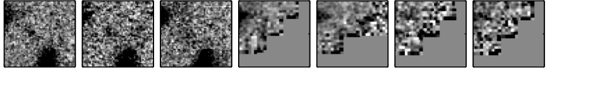

ID: 84045
reason: close to another source


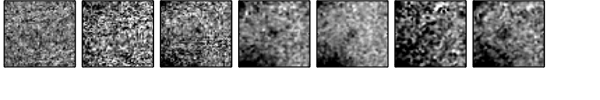

ID: 8517
reason: close to another source


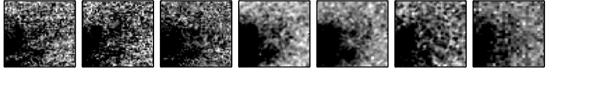

ID: 91679
reason: diffraction spike


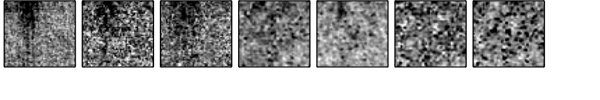

ID: 28933
reason: diffraction spike


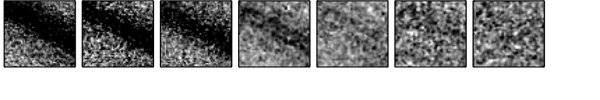

ID: 2970
reason: diffraction spike


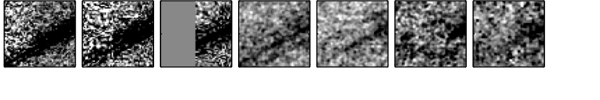

ID: 3120
reason: diffraction spike


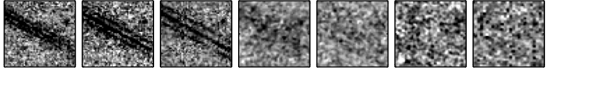

ID: 32120
reason: diffraction spike


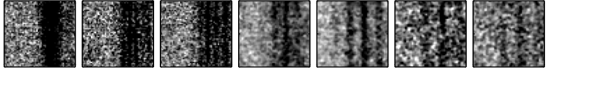

ID: 37652
reason: diffraction spike


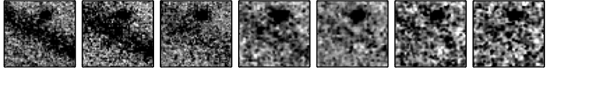

ID: 48726
reason: diffraction spike


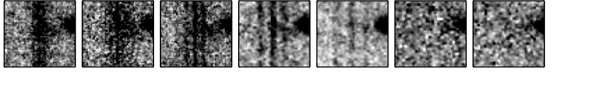

ID: 49569
reason: diffraction spike


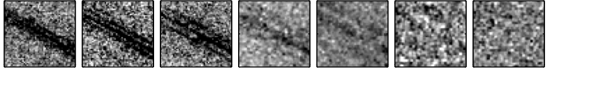

ID: 534
reason: diffraction spike


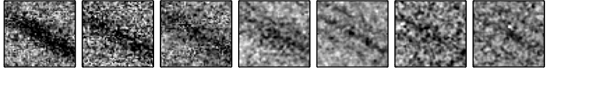

ID: 59589
reason: close to another source


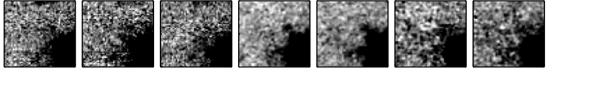

ID: 61063
reason: close to another source


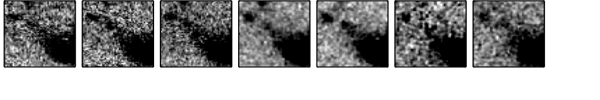

ID: 6464
reason: close to another source


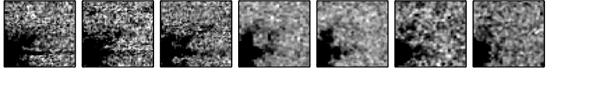

ID: 74030
reason: edge data


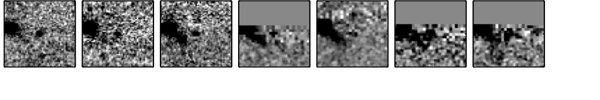

ID: 76485
reason: diffraction spike


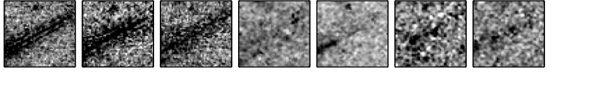

ID: 92875
reason: diffraction spike


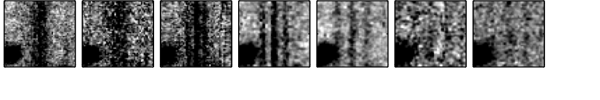

ID: 100379
reason: close to another source


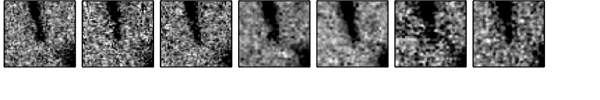

ID: 113
reason: diffraction spike


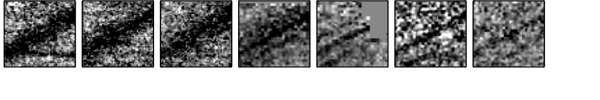

ID: 123
reason: diffraction spike


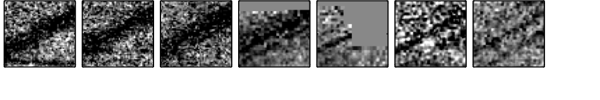

ID: 20952
reason: edge data


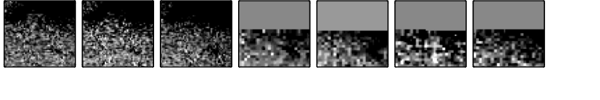

ID: 25495
reason: edge data


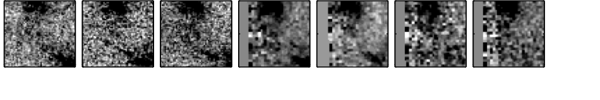

ID: 28497
reason: close to another source


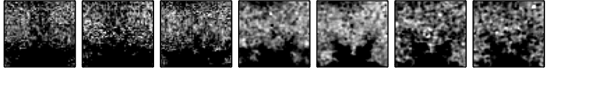

ID: 28722
reason: diffraction spike


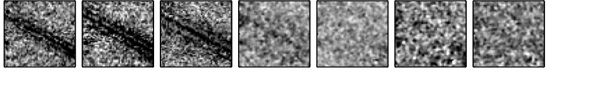

ID: 30051
reason: diffraction spike


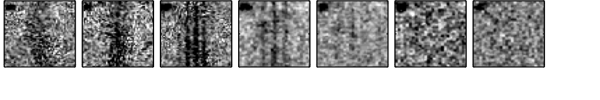

ID: 303
reason: diffraction spike


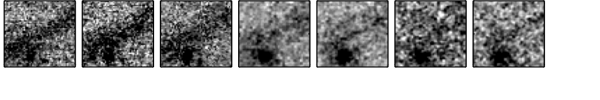

ID: 36874
reason: diffraction spike


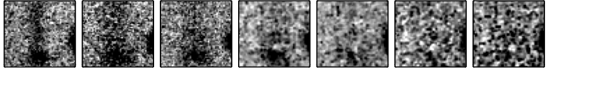

ID: 37970
reason: close to another source


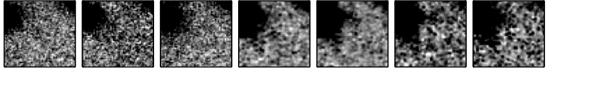

ID: 42600
reason: edge data


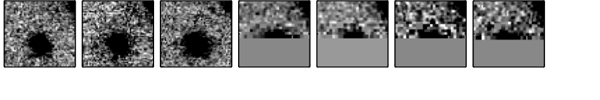

ID: 45251
reason: close to another source


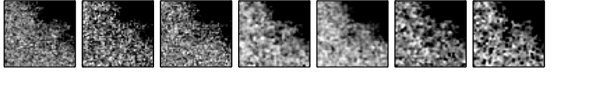

ID: 47645
reason: diffraction spike


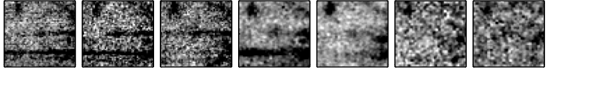

ID: 50271
reason: diffraction spike


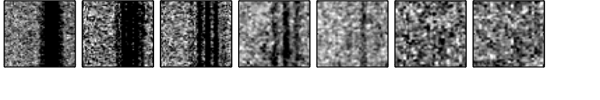

ID: 55536
reason: diffraction spike


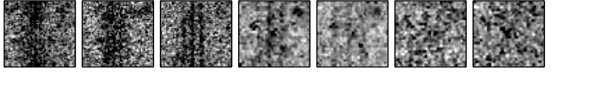

ID: 55735
reason: diffraction spike


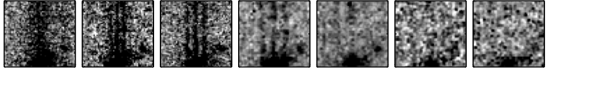

ID: 56048
reason: diffraction spike


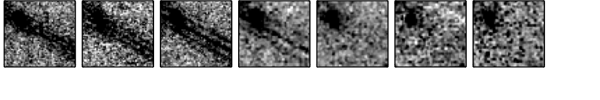

ID: 56302
reason: diffraction spike


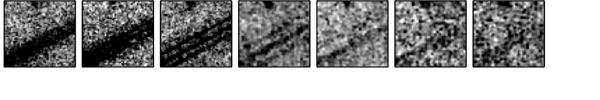

ID: 60144
reason: diffraction spike


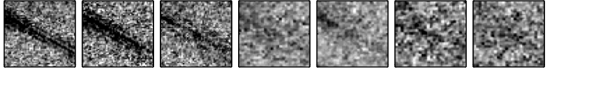

ID: 6536
reason: close to another source


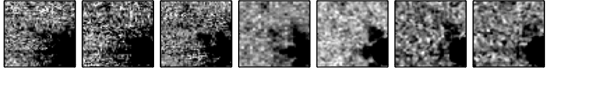

ID: 78149
reason: close to another source


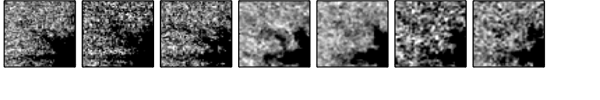

ID: 92855
reason: diffraction spike


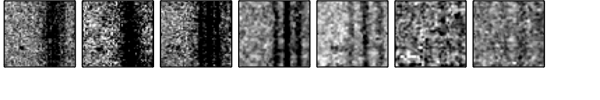

ID: 92873
reason: diffraction spike


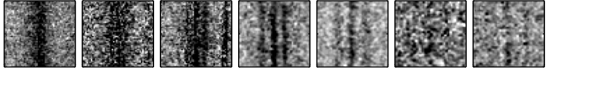

ID: 92876
reason: diffraction spike


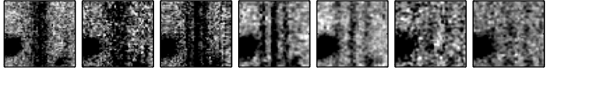

ID: 99338
reason: close to another source


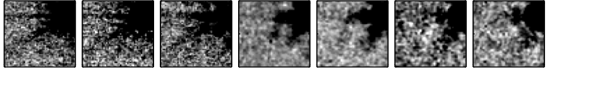

In [64]:
for i in range(len(filenames)):
    if df['label'][i] == 0:
        print('ID:',IDs[i])
        print('reason:', df['reason'][i])
        image = Image.open(filenames[i])
        resized_image = image.resize((600,100))
        display(resized_image)